<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/02_nice_with_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [244]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [245]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow, forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [246]:
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.25,
                                                   random_state=42)

X_train = (X_train - X_train.min()) / (X_train.max()-X_train.min())

train_data = Data(X_train)


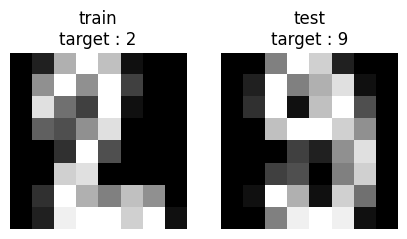

In [247]:
random_number = torch.randint(0,9,[1]).item()
image_train, category_train = X_train[random_number], y_train[random_number]
image_test, category_test = X_test[random_number], y_test[random_number]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((8,8)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((8,8)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [248]:
data_dim = 8*8

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=512, num_flows=10)

train_loader = DataLoader(train_data, batch_size=250, shuffle=True)


In [249]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  105.10135904947917
Epoch :  2   -----------> Loss :  90.79298909505208
Epoch :  3   -----------> Loss :  88.71715418497722
Epoch :  4   -----------> Loss :  86.87984975179036
Epoch :  5   -----------> Loss :  85.01716486612956
Epoch :  6   -----------> Loss :  83.26956558227539
Epoch :  7   -----------> Loss :  81.34019597371419
Epoch :  8   -----------> Loss :  79.39606094360352
Epoch :  9   -----------> Loss :  77.4429079691569
Epoch :  10   -----------> Loss :  75.53438949584961
Epoch :  11   -----------> Loss :  73.61175918579102
Epoch :  12   -----------> Loss :  71.70765431722005
Epoch :  13   -----------> Loss :  69.7876459757487
Epoch :  14   -----------> Loss :  67.8788350423177
Epoch :  15   -----------> Loss :  65.99890263875325
Epoch :  16   -----------> Loss :  64.11991628011067
Epoch :  17   -----------> Loss :  62.20180702209473
Epoch :  18   -----------> Loss :  60.33304977416992
Epoch :  19   -----------> Loss :  58.445831298828125
Epo

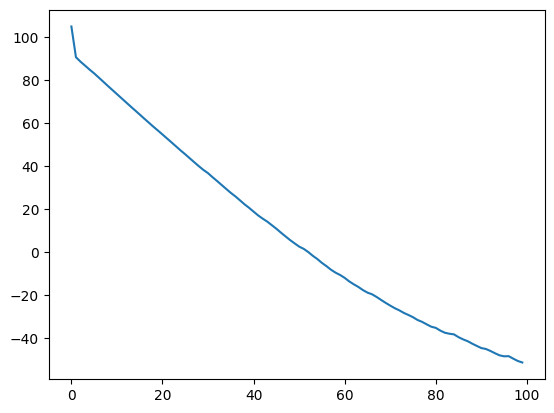

In [250]:
plt.plot(COST)

In [251]:
test = prior.sample((50,))
test

tensor([[-1.5836, -0.7991, -1.7307,  ...,  0.5213,  0.4076, -0.4704],
        [ 1.4609, -0.9423,  0.7375,  ..., -0.0294,  0.8568, -1.0150],
        [ 0.6114, -0.2329, -1.1813,  ...,  2.3840, -0.0273, -0.0692],
        ...,
        [ 0.6032, -0.1128, -0.3851,  ...,  0.2670, -0.2187, -0.3719],
        [ 0.3750,  1.0516,  0.7321,  ...,  0.5912,  0.7825,  0.1343],
        [-0.2919, -0.0835, -1.0445,  ..., -0.5798, -0.2706, -0.0759]])

In [252]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 1.2372e-02, -5.3699e-02,  6.2285e-01,  ..., -2.4153e-02,
          4.1929e-02,  1.1417e-01],
        [ 4.5174e-02, -5.6371e-02, -2.4996e-02,  ...,  7.0601e-01,
          2.3991e-01,  8.0467e-02],
        [ 7.8825e-04,  1.5549e-01,  1.1604e+00,  ...,  3.6307e-01,
          8.4531e-02,  7.0527e-02],
        ...,
        [-1.3737e-02,  5.3188e-03,  7.5435e-02,  ...,  6.1845e-01,
          1.4406e-01, -8.3830e-03],
        [ 2.8728e-02,  9.6774e-03,  6.0409e-01,  ...,  1.0964e+00,
          7.2555e-01, -1.2913e-01],
        [-2.7257e-02, -1.3597e-01,  2.6951e-02,  ...,  8.5416e-01,
          5.8267e-01,  1.9965e-01]], grad_fn=<MulBackward0>)

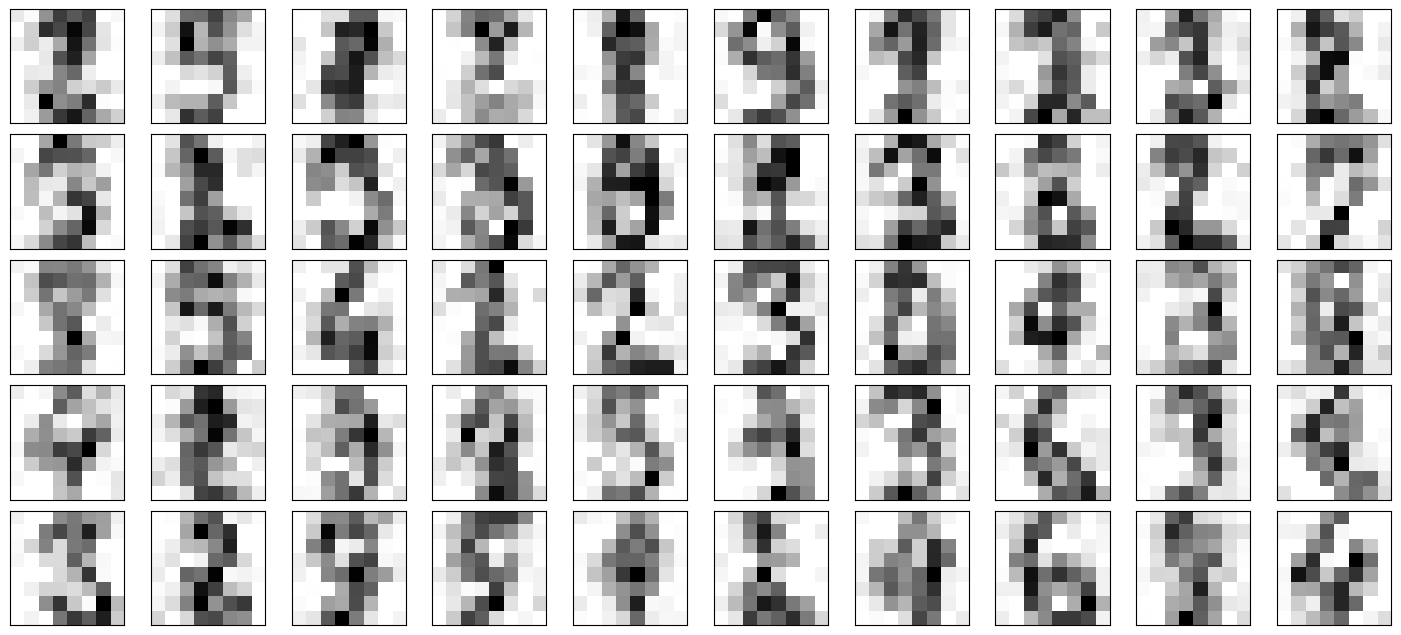

In [253]:
test = prior.sample((1797,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow(torch.nn.ReLU()(sonuc[i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[1, i].imshow(torch.nn.ReLU()(sonuc[10+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[2, i].imshow(torch.nn.ReLU()(sonuc[20+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[3, i].imshow(torch.nn.ReLU()(sonuc[30+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
    axs[4, i].imshow(torch.nn.ReLU()(sonuc[40+i]).detach().numpy().reshape((8,8)), cmap='binary', interpolation='nearest')
fig.show()


In [254]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
#pca.fit(sonuc)

In [255]:
forward, logdet_j = model.forward(torch.tensor(X_test))
backward = model.f_inv(forward)

In [256]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(backward.detach().numpy())          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(450, 2)


In [257]:
projected_raw = pca.fit_transform(X_test)          #sonuc.detach().numpy()
print(digits.data.shape)
print(projected_raw.shape)

(1797, 64)
(450, 2)


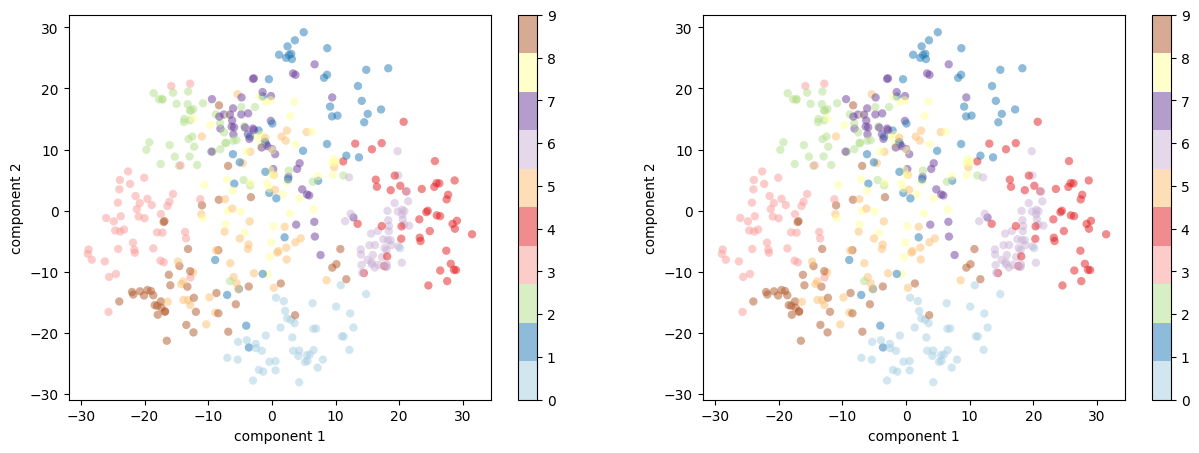

In [258]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 2, 1)
im1 = ax1.scatter(projected_raw[:, 0], projected_raw[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax1.set_xlabel('component 1')
ax1.set_ylabel('component 2')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.get_cmap('Paired', 10))
ax2.set_xlabel('component 1')
ax2.set_ylabel('component 2')
plt.colorbar(im2, ax=ax2)

plt.show()